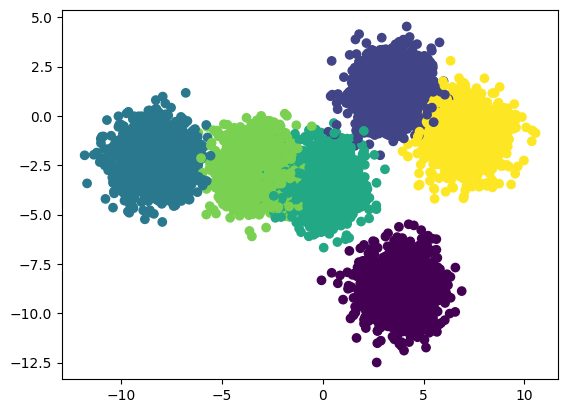

In [24]:
import manify
import torch
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from typing import Callable, Tuple, Optional
import torch
from torch import Tensor

from sklearn.datasets import make_blobs

device = "cpu"

# Make data
X, y = make_blobs(n_samples=8000, centers=6, n_features=2, random_state=500)
X = torch.tensor(X, dtype=torch.float32, device=device)
y = torch.tensor(y, dtype=torch.long, device=device)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Plot data
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

In [25]:
def train_model(model, X_train, y_train, A_hat=None, num_epochs=1000, lr=0.01):
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    progress_bar = tqdm(total=num_epochs)

    for i in range(num_epochs):
        # Forward pass
        if A_hat is not None:
            y_pred = model(X_train, A_hat)
        else:
            y_pred = model(X_train)

        # Compute loss
        loss = loss_fn(y_pred, y_train)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update progress bar
        progress_bar.update(1)
        progress_bar.set_postfix(loss=loss.item())

    return model


def evaluate_model(model, X_test, y_test, A_hat=None):
    with torch.no_grad():
        if A_hat is not None:
            y_pred = model(X_test, A_hat)
        else:
            y_pred = model(X_test)

        acc = (y_pred.argmax(dim=1) == y_test).float().mean()
    return acc.item()


In [28]:
num_classes = len(torch.unique(y_train))

# Basic MLP classifier
mlp = torch.nn.Sequential(torch.nn.Linear(2, 2, bias=False), torch.nn.ReLU(), torch.nn.Linear(2, num_classes))
mlp = train_model(mlp, X_train, y_train)
mlp_accuracy = evaluate_model(mlp, X_test, y_test)
print(f"MLP accuracy: {mlp_accuracy}")

# KappaGCN (setting kappa to 2e-4 ensures we hit the non-Euclidean case in get_logits)
pm = manify.manifolds.ProductManifold([(0, 2)], stereographic=True)
kgcn = manify.predictors.kappa_gcn.KappaGCN(
    pm=pm, output_dim=num_classes, hidden_dims=[2], nonlinearity=torch.relu, task="classification"
)
kgcn = train_model(kgcn, X_train, y_train, A_hat=torch.eye(X_train.shape[0]))
kgcn_accuracy = evaluate_model(kgcn, X_test, y_test, A_hat=torch.eye(X_test.shape[0]))
print(f"KappaGCN-MLP accuracy: {kgcn_accuracy}")

  0%|          | 0/1000 [00:00<?, ?it/s]

MLP accuracy: 0.9543750286102295


  0%|          | 0/1000 [00:00<?, ?it/s]

KappaGCN-MLP accuracy: 0.9743750095367432


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a multinomial logistic regression model
log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

# Evaluate the model
log_reg_accuracy = log_reg.score(X_test_scaled, y_test)
print(f"Logistic Regression accuracy: {log_reg_accuracy}")



pm = manify.manifolds.ProductManifold([(0, 2)], stereographic=True)
kgcn = manify.predictors.kappa_gcn.KappaGCN(
    pm=pm, output_dim=num_classes, hidden_dims=[], nonlinearity=torch.relu, task="classification"
)
kgcn = train_model(kgcn, X_train, y_train, A_hat=torch.eye(X_train.shape[0]))
kgcn_accuracy = evaluate_model(kgcn, X_test, y_test, A_hat=torch.eye(X_test.shape[0]))
print(f"KappaGCN-MLR accuracy: {kgcn_accuracy}")

Logistic Regression accuracy: 0.97125


/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

KappaGCN-MLR accuracy: 0.9743750095367432


In [15]:
pm = manify.manifolds.ProductManifold([(0, 1),(0,1)], stereographic=True)
kgcn = manify.predictors.kappa_gcn.KappaGCN(
    pm=pm, output_dim=num_classes, hidden_dims=[2], nonlinearity=torch.relu, task="classification"
)
kgcn = train_model(kgcn, X_train, y_train)
kgcn_accuracy = evaluate_model(kgcn, X_test, y_test)
print(f"KappaGCN-Product GCN accuracy: {kgcn_accuracy}")

  0%|          | 0/1000 [00:00<?, ?it/s]

KappaGCN-Product GCN accuracy: 0.9725000262260437


In [16]:
pm = manify.manifolds.ProductManifold([(0, 1),(0,1)], stereographic=True)
kgcn = manify.predictors.kappa_gcn.KappaGCN(
    pm=pm, output_dim=num_classes, hidden_dims=[2], nonlinearity=torch.relu, task="classification"
)
kgcn = train_model(kgcn, X_train, y_train,A_hat=torch.eye(X_train.shape[0]))
kgcn_accuracy = evaluate_model(kgcn, X_test, y_test,A_hat=torch.eye(X_test.shape[0]))
print(f"KappaGCN-Product MLP accuracy: {kgcn_accuracy}")

  0%|          | 0/1000 [00:00<?, ?it/s]

KappaGCN-Product MLP accuracy: 0.9737499952316284


In [18]:

pm = manify.manifolds.ProductManifold([(0, 1),(0,1)], stereographic=True)
kgcn = manify.predictors.kappa_gcn.KappaGCN(
    pm=pm, output_dim=num_classes, hidden_dims=[], nonlinearity=torch.relu, task="classification"
)
kgcn = train_model(kgcn, X_train, y_train,A_hat=torch.eye(X_train.shape[0]))
kgcn_accuracy = evaluate_model(kgcn, X_test, y_test,A_hat=torch.eye(X_test.shape[0]))
print(f"KappaGCN-Product MLR accuracy: {kgcn_accuracy}")


  0%|          | 0/1000 [00:00<?, ?it/s]

KappaGCN-Product MLR accuracy: 0.9681249856948853


In [19]:
pm = manify.manifolds.ProductManifold([(-1, 2)], stereographic=True)
kgcn = manify.predictors.kappa_gcn.KappaGCN(
    pm=pm, output_dim=num_classes, hidden_dims=[2], nonlinearity=torch.relu, task="classification"
)
kgcn = train_model(kgcn, X_train, y_train)
kgcn_accuracy = evaluate_model(kgcn, X_test, y_test)
print(f"KappaGCN-Kappa GCN accuracy: {kgcn_accuracy}")

  0%|          | 0/1000 [00:00<?, ?it/s]

KappaGCN-Kappa GCN accuracy: 0.9706249833106995


In [20]:
pm = manify.manifolds.ProductManifold([(-1, 2)], stereographic=True)
kgcn = manify.predictors.kappa_gcn.KappaGCN(
    pm=pm, output_dim=num_classes, hidden_dims=[2], nonlinearity=torch.relu, task="classification"
)
kgcn = train_model(kgcn, X_train, y_train,A_hat=torch.eye(X_train.shape[0]))
kgcn_accuracy = evaluate_model(kgcn, X_test, y_test,A_hat=torch.eye(X_test.shape[0]))
print(f"KappaGCN-Kappa MLP accuracy: {kgcn_accuracy}")

  0%|          | 0/1000 [00:00<?, ?it/s]

KappaGCN-Kappa MLP accuracy: 0.96875


In [21]:
pm = manify.manifolds.ProductManifold([(-1, 2)], stereographic=True)
kgcn = manify.predictors.kappa_gcn.KappaGCN(
    pm=pm, output_dim=num_classes, hidden_dims=[], nonlinearity=torch.relu, task="classification"
)
kgcn = train_model(kgcn, X_train, y_train,A_hat=torch.eye(X_train.shape[0]))
kgcn_accuracy = evaluate_model(kgcn, X_test, y_test,A_hat=torch.eye(X_test.shape[0]))
print(f"KappaGCN-Kappa MLR accuracy: {kgcn_accuracy}")

  0%|          | 0/1000 [00:00<?, ?it/s]

KappaGCN-Kappa MLR accuracy: 0.9706249833106995


In [22]:
pm = manify.manifolds.ProductManifold([(0, 2)], stereographic=True)
kgcn = manify.predictors.kappa_gcn.KappaGCN(
    pm=pm, output_dim=num_classes, hidden_dims=[2], nonlinearity=torch.relu, task="classification"
)
kgcn = train_model(kgcn, X_train, y_train)
kgcn_accuracy = evaluate_model(kgcn, X_test, y_test)
print(f"KappaGCN-GCN accuracy: {kgcn_accuracy}")

  0%|          | 0/1000 [00:00<?, ?it/s]

KappaGCN-GCN accuracy: 0.9743750095367432


In [ ]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from scipy.stats import wilcoxon
import pandas as pd
from sklearn.metrics import accuracy_score

results = pd.DataFrame(columns=["trial", "mlp", "kappa_mlp", "mlr", "kappa_mlr"])
for i in range(30):
    X, y = pm.gaussian_mixture(num_points=1000, num_classes=2, num_clusters=3)
    # X = X.detach().cpu().numpy()
    # y = y.detach().cpu().numpy()
    X = X.detach().cpu()
    y = y.detach().cpu()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
    mlp = torch.nn.Sequential(torch.nn.Linear(2, 2, bias=False), torch.nn.ReLU(), torch.nn.Linear(2, num_classes))
    mlp = train_model(mlp, X_train, y_train)
    mlp_accuracy = evaluate_model(mlp, X_test, y_test)

    pm = manify.manifolds.ProductManifold([(0, 2)], stereographic=True)
    kgcn = manify.predictors.kappa_gcn.KappaGCN(
        pm=pm, output_dim=num_classes, hidden_dims=[2], nonlinearity=torch.relu, task="classification"
    )
    kgcn = train_model(kgcn, X_train, y_train, A_hat=torch.eye(X_train.shape[0]))
    kgcnmlp_accuracy = evaluate_model(kgcn, X_test, y_test, A_hat=torch.eye(X_test.shape[0]))

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train a multinomial logistic regression model
    log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
    log_reg.fit(X_train_scaled, y_train)

    # Evaluate the model
    log_reg_accuracy = log_reg.score(X_test_scaled, y_test)

    kgcn = manify.predictors.kappa_gcn.KappaGCN(
        pm=pm, output_dim=num_classes, hidden_dims=[], nonlinearity=torch.relu, task="classification"
    )
    kgcn = train_model(kgcn, X_train, y_train, A_hat=torch.eye(X_train.shape[0]))
    kgcnmlr_accuracy = evaluate_model(kgcn, X_test, y_test, A_hat=torch.eye(X_test.shape[0]))



    results.loc[i] = {"trial": i, "mlp": mlp_accuracy, "kappa_mlp": kgcnmlp_accuracy, "mlr": log_reg_accuracy,
                      "kappa_mlr": kgcnmlr_accuracy}

print(results)
print(wilcoxon(results["mlp"], results["kappa_mlp"]))
print(wilcoxon(results["mlr"], results["kappa_mlr"]))


/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/torch/distributions/wishart.py:275: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/torch/distributions/wishart.py:275: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/torch/distributions/wishart.py:275: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/torch/distributions/wishart.py:275: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/torch/distributions/wishart.py:275: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/torch/distributions/wishart.py:275: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/torch/distributions/wishart.py:275: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/torch/distributions/wishart.py:275: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/torch/distributions/wishart.py:275: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/torch/distributions/wishart.py:275: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/torch/distributions/wishart.py:275: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/torch/distributions/wishart.py:275: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/torch/distributions/wishart.py:275: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/torch/distributions/wishart.py:275: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/torch/distributions/wishart.py:275: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/torch/distributions/wishart.py:275: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/torch/distributions/wishart.py:275: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/torch/distributions/wishart.py:275: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/torch/distributions/wishart.py:275: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/torch/distributions/wishart.py:275: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/torch/distributions/wishart.py:275: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/torch/distributions/wishart.py:275: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/torch/distributions/wishart.py:275: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/torch/distributions/wishart.py:275: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/torch/distributions/wishart.py:275: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/torch/distributions/wishart.py:275: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/torch/distributions/wishart.py:275: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/torch/distributions/wishart.py:275: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/torch/distributions/wishart.py:275: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/torch/distributions/wishart.py:275: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

    trial    mlp  kappa_mlp    mlr  kappa_mlr
0       0  0.920      0.920  0.920      0.920
1       1  0.930      0.925  0.925      0.925
2       2  0.805      0.900  0.900      0.900
3       3  0.880      0.885  0.885      0.885
4       4  0.770      0.645  0.645      0.645
5       5  0.975      0.975  0.975      0.975
6       6  0.725      0.695  0.695      0.695
7       7  0.885      0.885  0.885      0.885
8       8  0.945      0.945  0.945      0.945
9       9  0.890      0.875  0.875      0.875
10     10  0.805      0.715  0.715      0.715
11     11  0.810      0.805  0.805      0.805
12     12  0.745      0.705  0.705      0.705
13     13  0.915      0.915  0.910      0.915
14     14  0.665      0.705  0.705      0.705
15     15  0.965      0.975  0.975      0.975
16     16  0.695      0.675  0.675      0.675
17     17  0.990      0.990  0.990      0.990
18     18  0.870      0.865  0.865      0.865
19     19  0.955      0.935  0.935      0.935
20     20  0.810      0.790  0.790

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [40]:
results.mean()

trial        49.50000
mlp           0.81175
kappa_mlp     0.79460
mlr           0.79485
kappa_mlr     0.79470
dtype: float64

In [33]:
results

,trial,mlp,kappa_mlp,mlr,kappa_mlr
0,0,0.920,0.920,0.920,0.920
1,1,0.930,0.925,0.925,0.925
2,2,0.805,0.900,0.900,0.900
3,3,0.880,0.885,0.885,0.885
4,4,0.770,0.645,0.645,0.645
5,5,0.975,0.975,0.975,0.975
6,6,0.725,0.695,0.695,0.695
7,7,0.885,0.885,0.885,0.885
8,8,0.945,0.945,0.945,0.945
9,9,0.890,0.875,0.875,0.875


In [34]:
print(wilcoxon(results["mlp"], results["kappa_mlp"]))
print(wilcoxon(results["mlr"], results["kappa_mlr"]))

WilcoxonResult(statistic=63.0, pvalue=0.022043968679706958)
WilcoxonResult(statistic=216.5, pvalue=0.9827197228528591)


/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [52]:
# print(list(mlp.parameters()))
# get parameter as a dict   

mlp_dict = dict(mlp.named_parameters())
print(mlp_dict)

kgcn_dict = dict(kgcn.named_parameters())
print(kgcn_dict)

kgcn.state_dict()
print(kgcn.state_dict())

{'0.weight': Parameter containing:
tensor([[ 0.4922,  0.6803],
        [ 0.3027, -2.0610]], requires_grad=True), '2.weight': Parameter containing:
tensor([[-0.7402,  2.7696],
        [-0.2035, -2.9714]], requires_grad=True), '2.bias': Parameter containing:
tensor([0.7238, 0.3207], requires_grad=True)}
{'W_logits': Parameter containing:
tensor([[-0.2823, -0.2016],
        [-0.1168,  0.1318]], requires_grad=True), 'p_ks': Parameter on (Stereographic) manifold containing:
Parameter(ManifoldParameter([[ 0.4436,  0.6389],
                   [-0.8654,  0.6514]], requires_grad=True))}
OrderedDict([('W_logits', tensor([[-0.2823, -0.2016],
        [-0.1168,  0.1318]])), ('p_ks', tensor([[ 0.4436,  0.6389],
        [-0.8654,  0.6514]]))])


In [61]:
print(wilcoxon(results["mlp"], results["kappa_mlp"]))
print(wilcoxon(results["mlr"], results["torchmlr"]))
print(wilcoxon(results["mlr"], results["kappa_mlr"]))
#this is to troubleshoot a weird result
print(wilcoxon(results["kappa_mlp"], results["torchmlr"]))

WilcoxonResult(statistic=77.0, pvalue=0.021264654004563493)
WilcoxonResult(statistic=213.5, pvalue=0.9310022316924514)
WilcoxonResult(statistic=210.0, pvalue=0.8710567236303626)


ValueError: zero_method 'wilcox' and 'pratt' do not work if x - y is zero for all elements.

In [72]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from scipy.stats import wilcoxon
import pandas as pd
from sklearn.metrics import accuracy_score
num_classes=2
results = pd.DataFrame(columns=["trial", "mlp", "kappa_mlp", "mlr", "torchmlr","kappa_mlr"])
for i in range(30):
    X, y = pm.gaussian_mixture(num_points=1000, num_classes=2, num_clusters=3)
    # X = X.detach().cpu().numpy()
    # y = y.detach().cpu().numpy()
    X = X.detach().cpu()
    y = y.detach().cpu()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
    mlp = torch.nn.Sequential(torch.nn.Linear(2, 2, bias=False), torch.nn.ReLU(), torch.nn.Linear(2, num_classes))
    mlp = train_model(mlp, X_train, y_train, num_epochs=1000)
    mlp_accuracy = evaluate_model(mlp, X_test, y_test)

    pm = manify.manifolds.ProductManifold([(0, 2)], stereographic=True)
    kgcn = manify.predictors.kappa_gcn.KappaGCN(
        pm=pm, output_dim=num_classes, hidden_dims=[2], nonlinearity=torch.relu, task="classification"
    )
    kgcn = train_model(kgcn, X_train, y_train, A_hat=torch.eye(X_train.shape[0]),num_epochs=1000)
    kgcnmlp_accuracy = evaluate_model(kgcn, X_test, y_test, A_hat=torch.eye(X_test.shape[0]))

    # scaler = StandardScaler()
    # X_train_scaled = scaler.fit_transform(X_train)
    # X_test_scaled = scaler.transform(X_test)
    # kgcn_untrain=manify.predictors.kappa_gcn.KappaGCN(
    #     pm=pm, output_dim=num_classes, hidden_dims=[2], nonlinearity=torch.relu, task="classification"
    # )
    # kgcn_untrain.layers[0].W.data = mlp.state_dict()['0.weight'].data
    # kgcn_untrain.W_logits.data = mlp.state_dict()['2.weight'].data
    # kgcn_untrain.p_ks.data=-mlp.state_dict()['2.bias'].data @ torch.pinverse(mlp.state_dict()['2.weight'].data)
    # kgcn_untrain_accuracy=evaluate_model(kgcn_untrain, X_test, y_test, A_hat=torch.eye(X_test.shape[0]))

    # mlp_untrain=torch.nn.Sequential(torch.nn.Linear(2, 2, bias=False), torch.nn.ReLU(), torch.nn.Linear(2, num_classes))
    # mlp_untrain.state_dict()["0.weight"].data = kgcn.layers[0].W.data
    # mlp_untrain.state_dict()['2.weight'].data= 4*kgcn.W_logits.data
    # mlp_untrain.state_dict()['2.bias'].data= -4 * torch.sum(kgcn.p_ks.data * kgcn.W_logits.data.t(), dim=1)
    # # mlp_untrain.layers[2].bias.data = -kgcn.p_ks.data @ kgcn.W_logits.data
    # mlp_untrain_accuracy=evaluate_model(mlp_untrain, X_test, y_test)

    # Train a multinomial logistic regression model
    log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
    log_reg.fit(X_train, y_train)
    # Evaluate the model
    log_reg_accuracy = log_reg.score(X_test, y_test)

    torch_log_reg = torch.nn.Sequential(torch.nn.Linear(2, num_classes))
    torch_log_reg = train_model(torch_log_reg, X_train, y_train,num_epochs=1000)
    # Evaluate the model
    torch_log_reg_accuracy = evaluate_model(torch_log_reg, X_test, y_test)

    kgcn = manify.predictors.kappa_gcn.KappaGCN(
        pm=pm, output_dim=num_classes, hidden_dims=[], nonlinearity=torch.relu, task="classification"
    )
    kgcn = train_model(kgcn, X_train, y_train, A_hat=torch.eye(X_train.shape[0]),num_epochs=1000)
    kgcnmlr_accuracy = evaluate_model(kgcn, X_test, y_test, A_hat=torch.eye(X_test.shape[0]))



    # kgcn_untrain_accuracy=evaluate_model(kgcn_untrain, X_test, y_test, A_hat=torch.eye(X_test.shape[0]))

    results.loc[i] = {"trial": i, "mlp": mlp_accuracy, "kappa_mlp": kgcnmlp_accuracy,"mlr": log_reg_accuracy,
                      "torchmlr": torch_log_reg_accuracy,
                      "kappa_mlr": kgcnmlr_accuracy}

print(results)
print(results.mean())
#based on existing code, get a table of wilcoxcon between all values

print(wilcoxon(results["mlp"], results["kappa_mlp"]))
print(wilcoxon(results["mlr"], results["kappa_mlr"]))
#this is to troubleshoot a weird result


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kaizhudu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

    trial    mlp  kappa_mlp    mlr  torchmlr  kappa_mlr
0       0  0.780      0.720  0.720     0.720      0.720
1       1  0.710      0.670  0.670     0.670      0.670
2       2  0.695      0.670  0.670     0.670      0.670
3       3  0.785      0.760  0.760     0.760      0.760
4       4  0.840      0.845  0.845     0.845      0.845
5       5  0.780      0.850  0.850     0.850      0.850
6       6  0.795      0.820  0.820     0.820      0.820
7       7  0.845      0.875  0.875     0.875      0.875
8       8  0.770      0.890  0.890     0.890      0.890
9       9  0.775      0.675  0.675     0.675      0.675
10     10  0.735      0.720  0.720     0.720      0.720
11     11  0.805      0.760  0.760     0.760      0.760
12     12  0.705      0.735  0.735     0.735      0.735
13     13  0.840      0.890  0.890     0.890      0.890
14     14  0.895      0.910  0.910     0.910      0.910
15     15  0.855      0.885  0.885     0.885      0.885
16     16  0.860      0.860  0.860     0.860    

In [74]:
#write wilcoxon results between all values, when encounter expcetion makes the p value 1.0
models = ["mlp", "kappa_mlp", "mlr","torchmlr", "kappa_mlr"]
# Pairwise Wilcoxon signed rank test
for i in range(len(models)):
    for j in range(i + 1, len(models)):
        try:
            print(f"{models[i]} vs {models[j]}: {wilcoxon(results[models[i]], results[models[j]])}")
        except:
            print(f"{models[i]} vs {models[j]}: NaN")


mlp vs kappa_mlp: WilcoxonResult(statistic=147.5, pvalue=0.4768532259081154)
mlp vs mlr: WilcoxonResult(statistic=188.0, pvalue=0.5235489109355372)
mlp vs torchmlr: WilcoxonResult(statistic=147.5, pvalue=0.4768532259081154)
mlp vs kappa_mlr: WilcoxonResult(statistic=147.5, pvalue=0.4768532259081154)
kappa_mlp vs mlr: WilcoxonResult(statistic=128.0, pvalue=0.14225859268130034)
kappa_mlp vs torchmlr: NaN
kappa_mlp vs kappa_mlr: NaN
mlr vs torchmlr: WilcoxonResult(statistic=128.0, pvalue=0.14225859268130034)
mlr vs kappa_mlr: WilcoxonResult(statistic=128.0, pvalue=0.14225859268130034)
torchmlr vs kappa_mlr: NaN
